# Chapter 4: Neymanian Repeated Sampling Inference in Completely Randomized Experiments

In [1]:
import numpy as np
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt

font = {"family": "IBM Plex Sans Condensed", "weight": "normal", "size": 10}
plt.rc("font", **font)
plt.rcParams["figure.figsize"] = (7, 5)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(suppress=True)

%load_ext autoreload
%autoreload 1

%load_ext watermark
%watermark --iversions

matplotlib_inline: 0.1.6
pandas           : 2.1.1
scipy            : 1.11.3
statsmodels      : 0.13.5
matplotlib       : 3.8.0
numpy            : 1.23.5



In [2]:
def coverfn(truepar, point, varest):
    lowerCI = point - 1.96 * np.sqrt(varest)
    upperCI = point + 1.96 * np.sqrt(varest)
    return (lowerCI < truepar) & (truepar < upperCI)

In [3]:
def sampling_dist(z, y1, y0, n, n1, n0, tautrue=1):
    zmc = np.random.choice(z, size=n, replace=True)
    y = zmc * y1 + (1 - zmc) * y0
    tauhat = np.mean(y[zmc == 1]) - np.mean(y[zmc == 0])
    vhat = np.var(y[zmc == 1]) / n1 + np.var(y[zmc == 0]) / n0
    return tauhat, vhat, coverfn(tautrue, tauhat, vhat)

# Simulation Studies - Neyman CLT

In [4]:
n, n1, n0 = 100, 60, 40
tautrue = 1

# Simulation setting 1
y0 = np.random.exponential(1, n)
y0_1 = -np.sort(-y0)
y1_1 = y0_1 + tautrue
tautrue_1 = np.mean(y1_1) - np.mean(y0_1)
z_1 = z_2 = z_3 = np.repeat([0, 1], [n0, n1])
MC = int(1e4)
res1 = np.zeros((MC, 3))
for i in range(MC):
    res1[i] = sampling_dist(z_1, y1_1, y0_1, n=n, n1=n1, n0=n0, tautrue=1)
v1 = np.var(y1_1) / n1 + np.var(y0_1) / n0 - np.var(y1_1 - y0_1) / n

# Simulation setting 2
y0_2 = np.sort(y0)
y1_2 = y1_1
(tautrue_2 := np.mean(y1_1) - np.mean(y0_2))
res2 = np.zeros((MC, 3))
for i in range(MC):
    res2[i] = sampling_dist(z_2, y1_1, y0_2, n=n, n1=n1, n0=n0, tautrue=1)
v2 = np.var(y1_2) / n1 + np.var(y0_2) / n0 - np.var(y1_2 - y0_2) / n


# Simulation setting 3
y0_3 = np.random.permutation(y0_1)
y1_3 = y1_1
(tautrue_3 := np.mean(y1_3) - np.mean(y0_3))
res3 = np.zeros((MC, 3))
for i in range(MC):
    res3[i] = sampling_dist(z_3, y1_3, y0_3, n=n, n1=n1, n0=n0, tautrue=1)
v3 = np.var(y1_3) / n1 + np.var(y0_3) / n0 - np.var(y1_3 - y0_3) / n

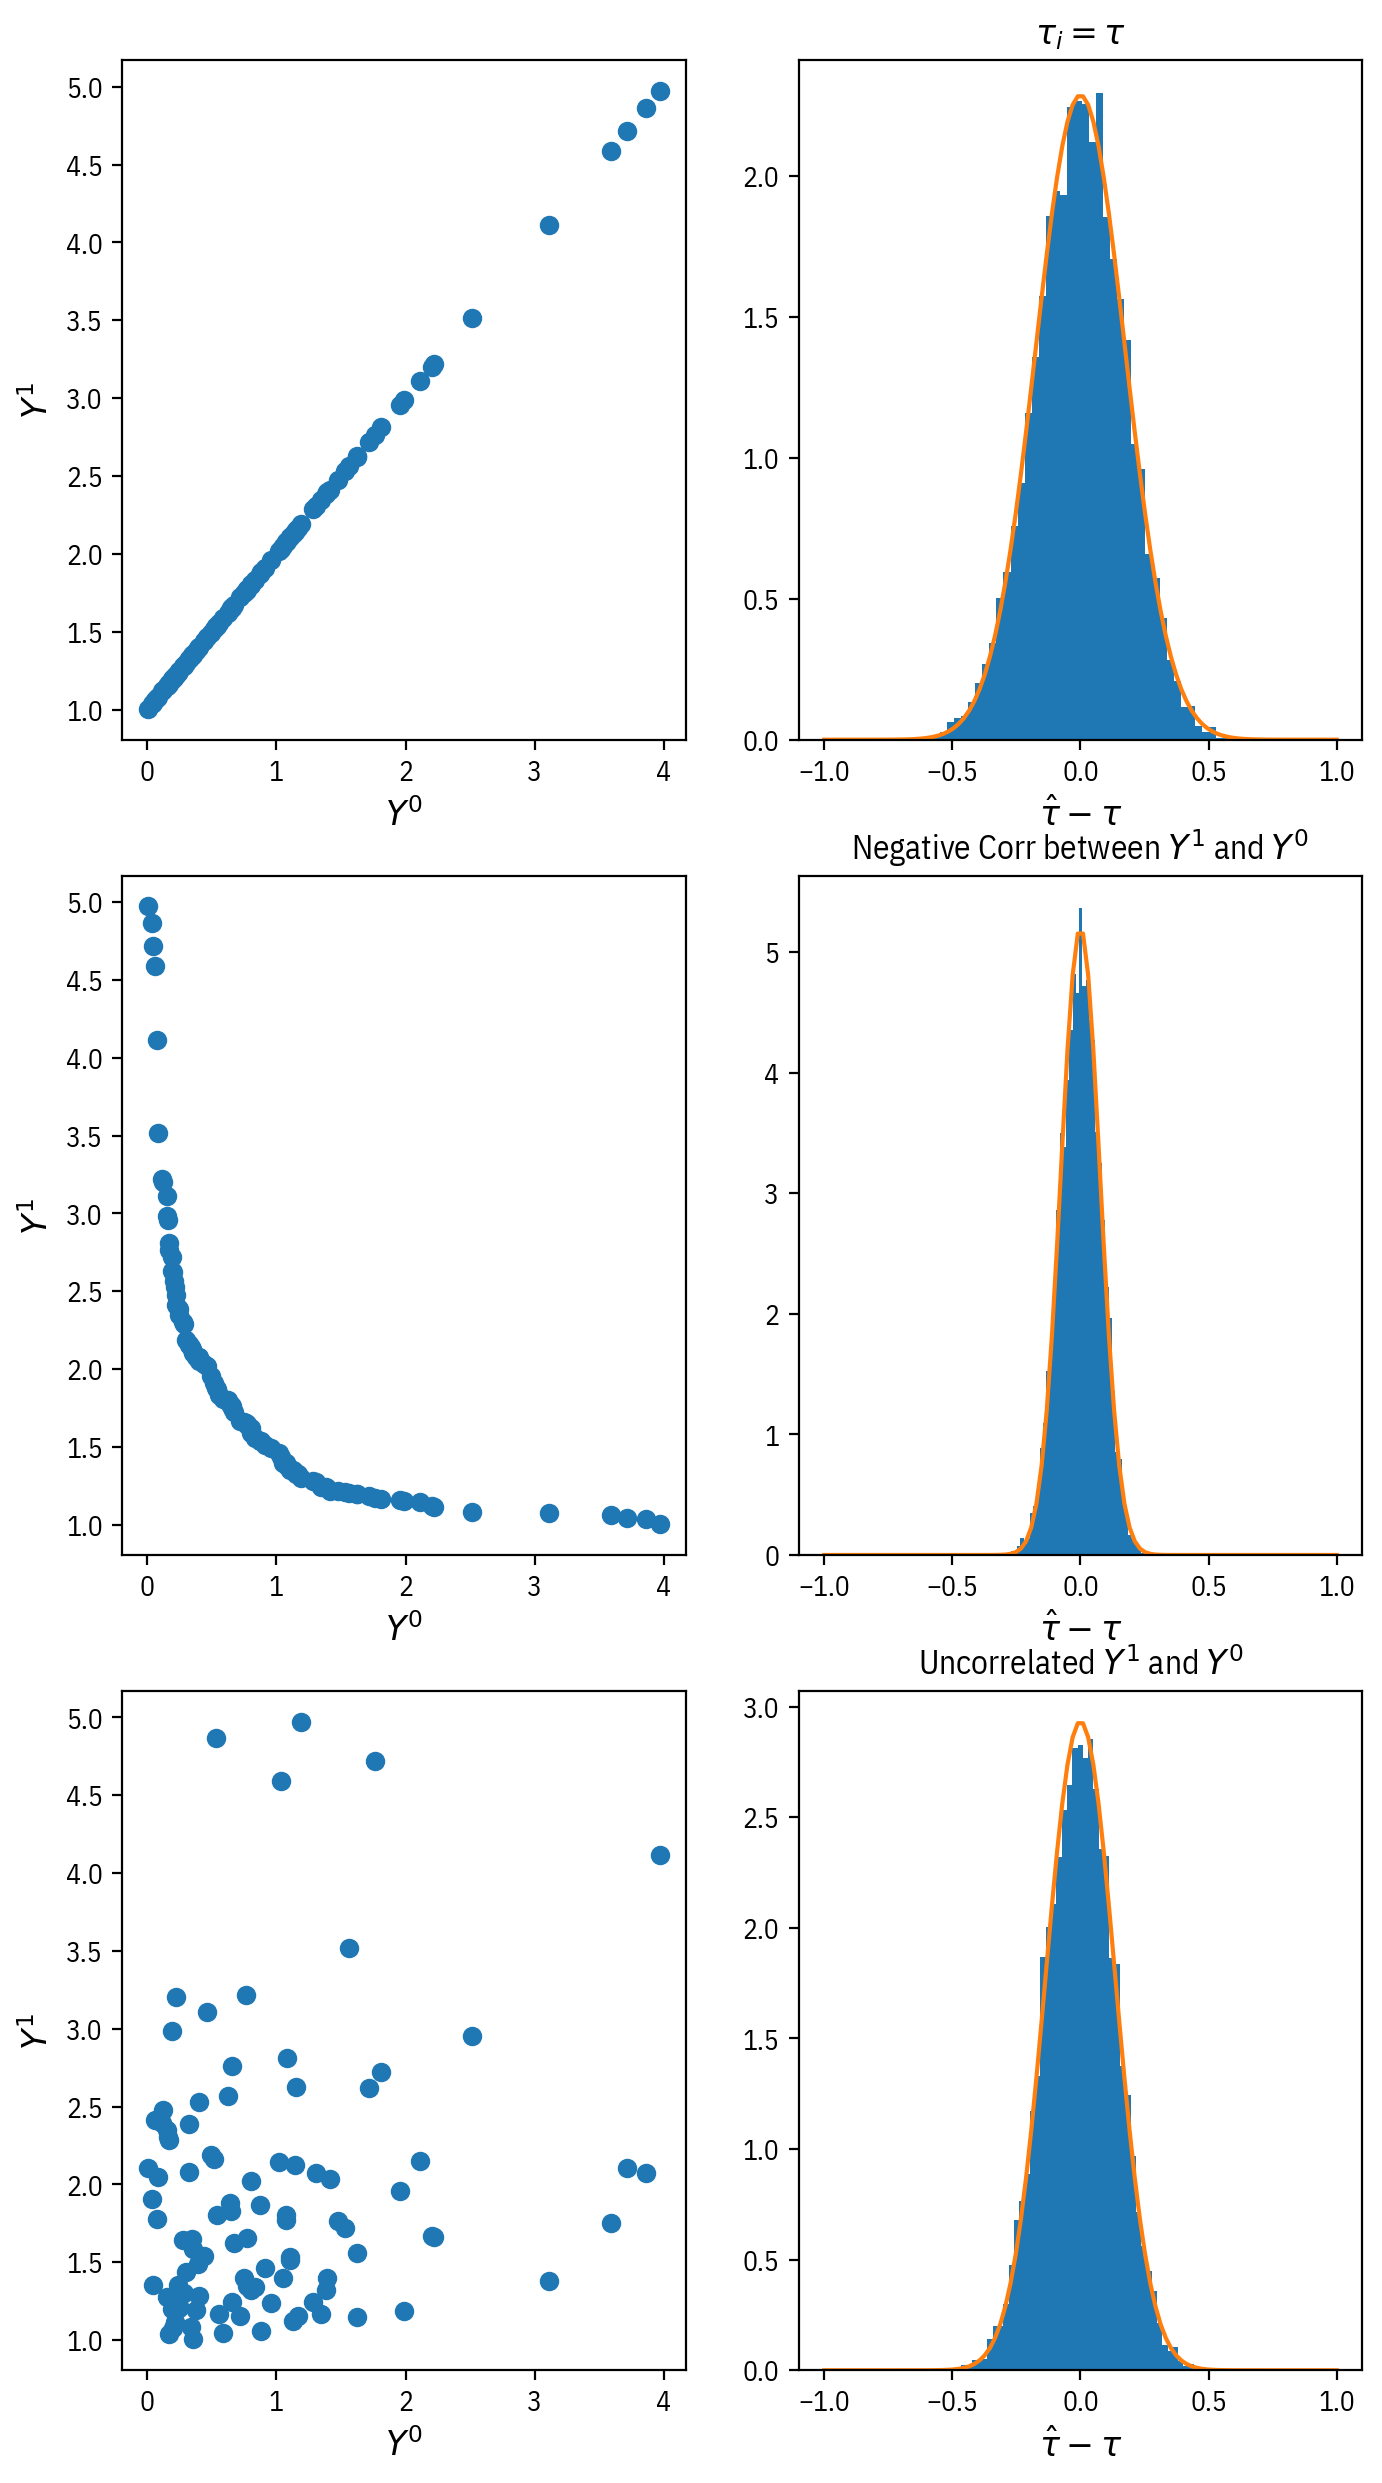

In [5]:
f, ax = plt.subplots(3, 2, figsize=(8, 15))
for i, (y0, y1, res, v) in enumerate(
    zip([y0_1, y0_2, y0_3], [y1_1, y1_2, y1_3], [res1, res2, res3], [v1, v2, v3])
):
    ax[i][0].plot(y0, y1, "o")
    ax[i][0].set_xlabel(r"$Y^0$", fontsize=12)
    ax[i][0].set_ylabel(r"$Y^1$", fontsize=12)
    ax[i][1].hist(res[:, 0] - tautrue, bins=50, density=True)
    ax[i][1].set_xlabel(r"$\hat{\tau} - \tau$", fontsize=12)
    x = np.linspace(-1, 1, 100)
    y = sp.stats.norm.pdf(x, loc=0, scale=np.sqrt(v))
    ax[i][1].plot(x, y, label="Neyman variance")
ax[0][1].set_title(r"$\tau_i = \tau$")
ax[1][1].set_title(r"Negative Corr between $Y^1$ and $Y^0$")
ax[2][1].set_title(r"Uncorrelated $Y^1$ and $Y^0$")
plt.show()

In [6]:
pd.DataFrame(
    np.c_[
        np.r_[np.var(res1[:, 0]), np.mean(res1[:, 1:3], axis=0)],
        np.r_[np.var(res2[:, 0]), np.mean(res2[:, 1:3], axis=0)],
        np.r_[np.var(res3[:, 0]), np.mean(res3[:, 1:3], axis=0)],
    ],
    columns=["Constant", "Negative", "Independent"],
    index=["Variance", "Estimated Variance", "Coverage"],
)

,Constant,Negative,Independent
Variance,0.031073,0.006261,0.019115
Estimated Variance,0.030088,0.030094,0.030080
Coverage,0.941100,0.999900,0.982800


## Heavy Tails: things break down

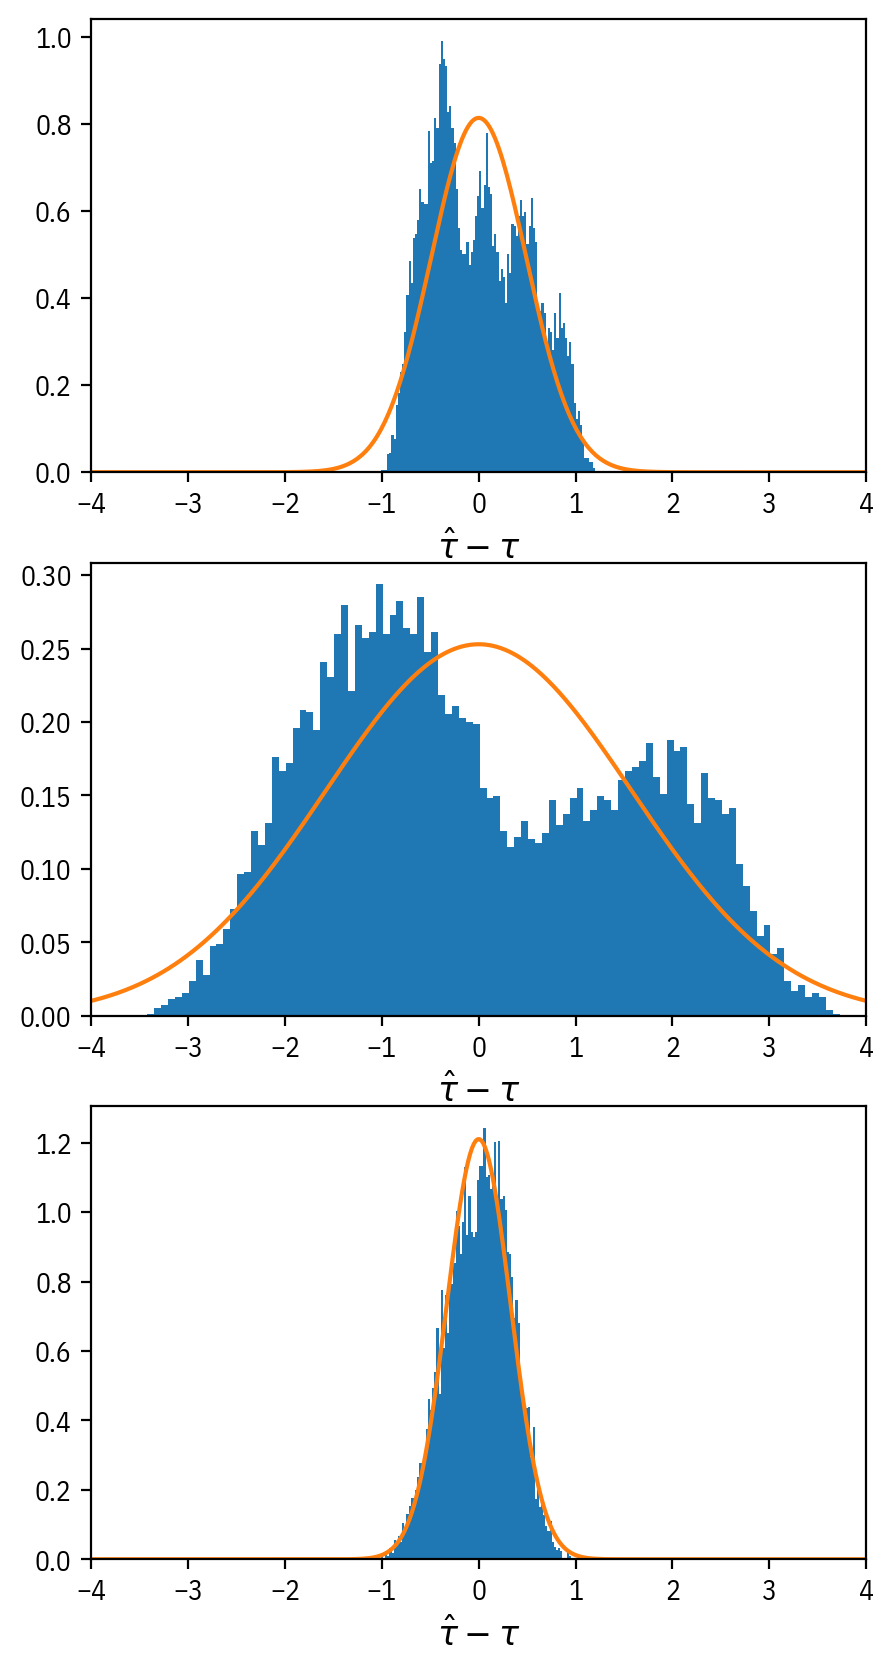

In [7]:
n, n1, n0 = 1000, 600, 400
tautrue = 1

# cauchy contamination: prob combination = 0.1
eps = np.random.binomial(1, 0.1, n)
y0_1 = (1 - eps) * np.random.exponential(1, n) + eps * np.random.standard_cauchy(n)
y1_1 = y0_1 + tautrue
tautrue_1 = np.mean(y1_1) - np.mean(y0_1)
z_1 = z_2 = z_3 = np.repeat([0, 1], [n0, n1])
MC = int(1e4)
res1 = np.zeros((MC, 3))
for i in range(MC):
    res1[i] = sampling_dist(z_1, y1_1, y0_1, n=n, n1=n1, n0=n0, tautrue=1)
v1 = np.var(y1_1) / n1 + np.var(y0_1) / n0 - np.var(y1_1 - y0_1) / n
v1

# cauchy contamination: prob combination = 0.3
eps = np.random.binomial(1, 0.3, n)
y0_2 = (1 - eps) * np.random.exponential(1, n) + eps * np.random.standard_cauchy(n)
y1_2 = y0_2 + tautrue
tautrue_2 = np.mean(y1_2) - np.mean(y0_2)
res2 = np.zeros((MC, 3))
for i in range(MC):
    res2[i] = sampling_dist(z_2, y1_2, y0_2, n=n, n1=n1, n0=n0, tautrue=1)
v2 = np.var(y1_2) / n1 + np.var(y0_2) / n0 - np.var(y1_2 - y0_2) / n
v2


# cauchy contamination: prob combination = 0.5
eps = np.random.binomial(1, 0.5, n)
y0_3 = (1 - eps) * np.random.exponential(1, n) + eps * np.random.standard_cauchy(n)
y1_3 = y0_3 + tautrue
tautrue_3 = np.mean(y1_3) - np.mean(y0_3)
res3 = np.zeros((MC, 3))
for i in range(MC):
    res3[i] = sampling_dist(z_3, y1_3, y0_3, n=n, n1=n1, n0=n0, tautrue=1)
v3 = np.var(y1_3) / n1 + np.var(y0_3) / n0 - np.var(y1_3 - y0_3) / n

v1, v2, v3

f, ax = plt.subplots(3, 1, figsize=(5, 10))
for i, (res, v) in enumerate(zip([res1, res2, res3], [v1, v2, v3])):
    ax[i].hist(res[:, 0] - tautrue, bins=100, density=True)
    ax[i].set_xlabel(r"$\hat{\tau} - \tau$", fontsize=12)
    x = np.linspace(-10, 10, 1000)
    y = sp.stats.norm.pdf(x, loc=0, scale=np.sqrt(v))
    ax[i].plot(x, y)
    ax[i].set_xlim(-4, 4)
plt.show()

# Application

In [8]:
from causalinference.utils import lalonde_data

y, z, _ = lalonde_data()
y *= 1000

In [9]:
n0, n1 = np.sum(1 - z), np.sum(z)
tauhat = np.mean(y[z == 1]) - np.mean(y[z == 0])
vhat = np.var(y[z == 1], ddof=1) / n1 + np.var(y[z == 0], ddof=1) / n0
sehat = np.sqrt(vhat)
tauhat, sehat

(1794.3430782016621, 670.9967300240978)

Homoskedastic

In [10]:
sm.OLS(y, sm.add_constant(z)).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,4554.8023,408.046,11.162,0.000,3752.856,5356.749
x1,1794.3431,632.854,2.835,0.005,550.575,3038.111


Heteroskedastic

In [11]:
sm.OLS(y, sm.add_constant(z)).fit(cov_type="HC0").summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,4554.8023,339.438,13.419,0.000,3889.515,5220.089
x1,1794.3431,669.316,2.681,0.007,482.509,3106.177


In [12]:
sm.OLS(y, sm.add_constant(z)).fit(cov_type="HC2").summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,4554.8023,340.093,13.393,0.000,3888.232,5221.373
x1,1794.3431,670.997,2.674,0.007,479.214,3109.473
